# Important note for correctors:
Place EastCoastRappers.csv and WestCoastRappers.csv in **SAME DIRECTORY** as this file is.

# Formalia:

Please read the [assignment overview page](https://github.com/SocialComplexityLab/socialgraphs2021/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc.), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Tuesday October the 31st, 2021 at 23:55. Hand in your IPython notebook file (with extension `.ipynb`) via http://peergrade.io/


(If you haven't set up an account on peergrade yet, go to www.peergrade.io/join and type in the class code: ***DPZEV6***.)

### Overview

This year's Assignment 2 is all about analyzing the network of rappers.

Note that this time I'm doing the exercises slightly differently in order to clean things up a bit. The issue is that the weekly lectures/exercises include quite a few instructions and intermediate results that are not quite something you guys can meaningfully answer. 

Therefore, in the assignment below, I have tried to reformulate the questions from the weekly exercises into something that is (hopefully) easier to answer. *Then I also note which lectures each question comes from*; that way, you can easily go back and find additional tips & tricks on how to solve things 😇


----

# Part 0: Building the network 

To create our network, we downloaded the rapper Wiki pages from each coast (during Week 4) and linked them via the hyperlinks connecting pages to each other. To achieve this goal we have used regular expressions.

> * 0.1. Explain the strategy you have used to extract the hyperlinks from the Wiki-pages, assuming that you have already collected the rapper pages with the Wikipedia API.
> * 0.2. Show the regular expressions you have built and explain in details how they work.

In [1]:
# Libraries that we will use through the notebook:
import numpy as np                  # arrays
import matplotlib.pyplot as plt     # plotting
import pandas as pd                 # DataFrames 
import nltk                         # Natural Language Processing
import re                           # regular expressions
import requests                     # working with URLs, request for opening and reading URLs
import networkx as nx               # network analysis
import powerlaw                     # power law analysis
from fa2 import ForceAtlas2
import community
import itertools
import matplotlib.cm as cm
import os
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from nltk.corpus import stopwords
from io import BytesIO
import random                       # label shuffling test
from scipy.stats import ttest_ind  # to calculate p values

## 0.1.Extracting hyperlinks
**Code + Explain strategy:** ("Assuming that you have **already collected the rapper pages** with the Wikipedia API")

Three functions were made:


* get_links:
    * Input: a rapper's wikipedia text
    * Output: the links in the rapper's wikipedia page
    * How: use of regular funcion 

 
* get_pageviews:
    * Input: name of the rapper as it appears in wikipedia API (provided in the .csv files "already collected")
    * Return: All links in rapper's Wikipedia page
    * How: 1) pulling a request for the json file, 2) working it and 3) calling get_links

 
* get_links_from_rapper_list:
    * Input: .csv file with a rappers's name in each column (file provided by Jonas)
    * Output: dataframe with same structure as input's but an extra column with the links.
    * How: loop over the rappers, in each: calling to get_pageviews and filtrating for the links to be rapppers' names.
     

In [2]:
# Function to extract links
def get_links(wikitext):
    links = re.findall(r"\[\[.*?\]\]", wikitext) #  all the text between [[ and ]]. 
    links = [link[2:-2].split("|")[0] for link in links] # removes the [[ and ]], splits on the | and takes the first part
    return links

# Function to download and extract links from a rapper's wikipedia page
def get_pageviews(page):
    baseurl = "https://en.wikipedia.org/w/api.php" #baseurl for wikipedia
    params = { 
        "action": "query",
        "prop": "revisions",
        "rvprop": "content",
        "format": "json",
        "titles": page
    }
    # Download the page using requests
    wikitext = requests.get(baseurl, params=params) # download the page
    wikijson = wikitext.json() # convert to json 
    wikitext=wikijson["query"]["pages"][list(wikijson["query"]["pages"].keys())[0]]['revisions'][0]['*'] # extract the text category
    links = get_links(wikitext) # extract ALL links
    return links

def get_links_from_rapper_list(ListOfRappers):

    for i in range(len(ListOfRappers)): # each rapper

        rapperEC_i= ListOfRappers.WikipediaPageName[i]
        links_i = get_pageviews(rapperEC_i) # get ALL the rapper's links

        #For each link check if it's a lint to another rapper's. If affirmative, keep it, else, discard.
        links_i[:] = [x for x in links_i if x in EastCoast.WikipediaPageName.values or x in WestCoast.WikipediaPageName.values]
        ListOfRappers.loc[i, "links"] = str(links_i) # add filtered links to the dataframe
    return ListOfRappers

In [3]:
# Charge names of rappers
EastCoast=pd.read_csv("EastCoastRappers.csv")
WestCoast=pd.read_csv("WestCoastRappers.csv")

In [4]:
# Get links for all rappers
EastCoast2 =get_links_from_rapper_list(EastCoast)
WestCoast2 = get_links_from_rapper_list(WestCoast)

In [5]:
# Save the dataframes into your computer
EastCoast2.iloc[:,1:3].to_csv("EastCoastRappers2.csv")
WestCoast2.iloc[:,1:3].to_csv("WestCoastRappers2.csv")

In [6]:
# Execute to see the shape of the new dataframe that will be saved in your computer as EastCoastRappers2.csv
(EastCoast2)

Unnamed: 0 WikipediaPageName  \
0             0           6ix9ine   
1             1        9th Prince   
2             2              22Gz   
3             3          38 Spesh   
4             4       The 45 King   
..          ...               ...   
442         442  Young Music DYMG   
443         443         Younglord   
444         444       Nosson Zand   
445         445         ZillaKami   
446         446       Mike Zombie   

                                                 links  
0    ['Fetty Wap', 'ZillaKami', 'Fetty Wap', 'Casan...  
1               ['RZA', 'RZA', 'Islord', 'Hell Razah']  
2    ['Casanova (rapper)', 'Pop Smoke', 'Sheff G', ...  
3    ['Styles P', 'Jadakiss', 'Fred the Godson', 'A...  
4    ['Apache (rapper)', 'Queen Latifah', 'Jay-Z', ...  
..                                                 ...  
442                                     ['Sean Combs']  
443  ['Sean Combs', 'Mase', 'Lloyd Banks', 'Consequ...  
444                                                 []  
445  ['6ix9ine', '6ix9ine', 'JPEGMafia', 'Necro (ra...  
446  ['Meek Mill', 'Jay-Z', 'French Montana', 'The ...  

[447 rows x 3 columns]

## 0.2. Regular expressions
**Explain how the expressions used in the charging code (previous cells) work.**

Regular expressions used (only one): 


`links = re.findall(r"\[\[.*?\]\]", wikitext)` \
This re goes through the text and saves in a list called `links` all the characters that are in the text in the shape of `[[` *whatever is inside* `]]` . 


Breakdown of the `\[\[.*?\]\]"` :
* <span style="color:green">.\* :</span> means "match any character except newline, as few times as possible"
* <span style="color:green">? :</span> The ".\*?" is a non-greedy version of .* - This means that tries to match the shortest possible string between  `[[ ]]`, else, since there are plenty of structures like that in the text, it would take all the text between the most external `[[ ]]`
*  `\[\[` and the  `\]\]` just sets the structure that we are looking for to save


**After the regular expression**, we added a pre processing of the links, since they often with a structure such as \
`'[[Actual-name-of-the-linked-page | name-where-the-link-is-embedded]]'`, \
The command is: 
`links = [link[2:-2].split("|")[0] for link in links]` and it removes the [[ and ]] in the extremes of each string representing a link and, splits each string on the "|" character, taking the first part with `[0]`, which is the actual name of the link for Wikipedia-API's names.


# Part 1: Network visualization and basic stats

Visualize your network of rappers (from lecture 5) and calculate stats (from lecture 4 and 5). For this exercise, we assume that you have already generated the network and extracted the largest weakly connected component (the "largest weakly connected component" of a directed network is the subgraph consisting of the nodes that would constitute the largest connected component if the network were undirected) . The visualization and statistics should be done for the largest weakly connected component only.

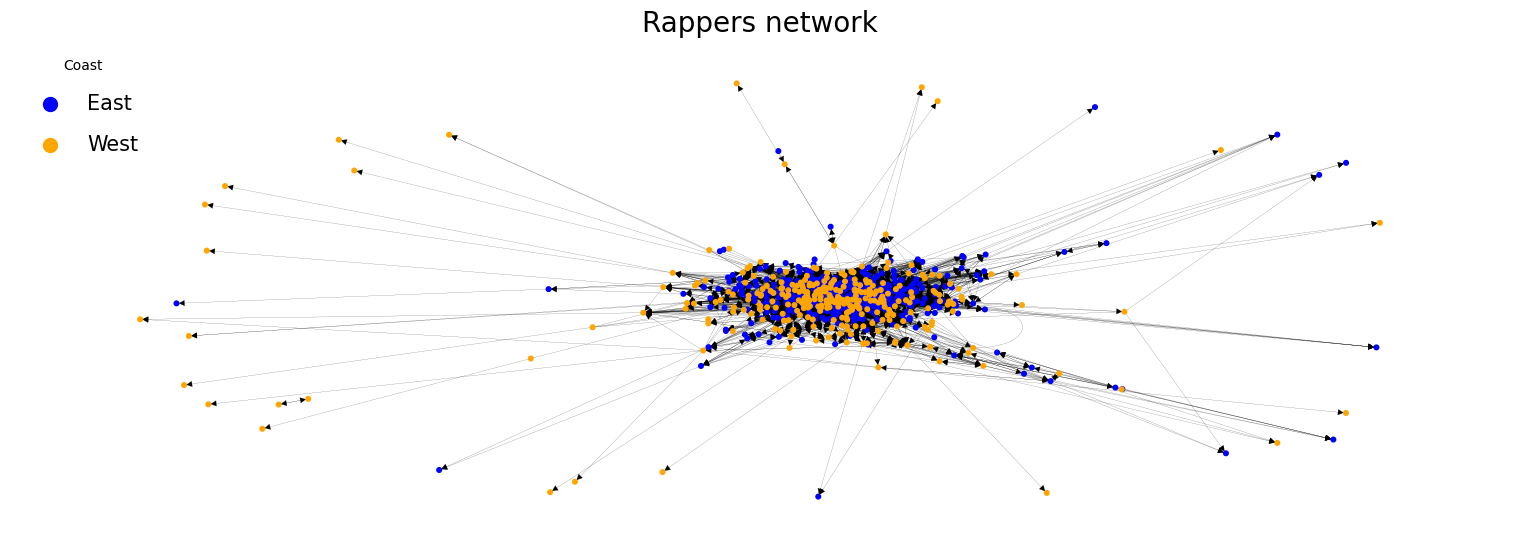

In [7]:
# GENERATE THE NETWORK - 30s

# load WestCoast2.csv and EastCoast2.csv (just saved last cells)
EastCoast2 = pd.read_csv("EastCoastRappers2.csv")
WestCoast2 = pd.read_csv("WestCoastRappers2.csv")
# Alternative way:
#EastCoast2 =get_links_from_rapper_list(EastCoast)
#WestCoast2 = get_links_from_rapper_list(WestCoast)

# 1) Create a directed graph
G_dir = nx.DiGraph()

# Add nodes with coast attribute
for i in range(len(EastCoast2)): #all rows (rappers)
    G_dir.add_node(EastCoast2.WikipediaPageName[i], coast="East")
for i in range(len(WestCoast2)):
    G_dir.add_node(WestCoast2.WikipediaPageName[i], coast="West")

# Add edges between rappers
for i in range(len(EastCoast2)):
    for link in eval(EastCoast2.links[i]): # eval() evaluates the string that EastCoast2.links[i] is as a python expression -> a list
        G_dir.add_edge(EastCoast2.WikipediaPageName[i], link)
for i in range(len(WestCoast2)):
    for link in eval(WestCoast2.links[i]):
        G_dir.add_edge(WestCoast2.WikipediaPageName[i], link)

# Take out isolated ones
isolated_nodes = [node for node in G_dir.nodes() if G_dir.in_degree(node) == 0 and G_dir.out_degree(node) == 0]
G_dir.remove_nodes_from(isolated_nodes)

# Plot the graph colouring East rappers blue and West rappers orange
plt.figure(figsize=(15,5))
pos = nx.spring_layout(G_dir, k=0.05,seed=1)
nx.draw(G_dir, pos, node_color=["blue" if G_dir.nodes[n]["coast"] == "East" else "orange" for n in G_dir.nodes], node_size=11, width=0.1, arrowsize=10, with_labels=False)
plt.scatter([],[], c="blue", alpha=1, s=100, label="East")
plt.scatter([],[], c="orange", alpha=1, s=100, label="West")
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title="Coast", loc="upper left", fontsize=15)
plt.title("Rappers network", fontsize=20)
plt.show()

# Extract the GCC and make it the new G_dir
a=list(nx.weakly_connected_components(G_dir))
gcc = max(nx.weakly_connected_components(G_dir), key=len)
gcc_graph = G_dir.subgraph(gcc).copy()
G_dir =gcc_graph

## _Exercise 1a_: Stats (see lecture 4 and 5 for more hints)

> Will repeat each question above each cell that answers it

> 1. What is the number of nodes in the network? 
> 2. What is the number of links?
> 3. Who is the top connected rapper? (Report results for the in-degrees and out-degrees). Comment on your findings. Is this what you would have expected?
> 4. Who are the top 5 most connected east-coast rappers (again in terms of in/out-degree)? 
> 5. Who are the top 5 most connected west-coast rappers (again in terms of in/out-degree)?
> 6. Plot the in- and out-degree distributions for the whole network. 
>       * Use axes that make sense for visualizing this particular distribution.
>       * What do you observe? 
>       * Give a pedagogical explaination of why the in-degree distribution is different from the out-degree distribution?
> 7. Find the exponent (by using the `powerlaw` package) for the in- and out-degree distributions. What does it say about our network?
> 8. Compare the two degree distributions two the degree distribution of a *random network* (undirected) with the same number of nodes and probability of connection *p*. Comment your results.

 * 1a.1. What is the number of nodes in the network? 
 * 1a.2. What is the number of links?

In [8]:
print("Nodes: ",nx.number_of_nodes(G_dir))
print("Links: ",nx.number_of_edges(G_dir))

Nodes:  728
Links:  5830


 * 1a.3. Who is the top connected rapper? (Report results for the in-degrees and out-degrees). Comment on your findings. Is this what you would have expected?

In [9]:
# Top connected rapper - will display 3 most connected ones

# In-degree
in_degrees = [(n, G_dir.in_degree(n)) for n in G_dir.nodes()]
in_degrees.sort(key=lambda x: x[1], reverse=True)
print("Top 5 rappers with most in-degrees:")
for n, d in in_degrees[:5]:
    print(f"{n:30s} {d:5d}")

# Out-degree
out_degrees = [(n, G_dir.out_degree(n)) for n in G_dir.nodes()]
out_degrees.sort(key=lambda x: x[1], reverse=True)
print("Top 5 rappers with most out-degrees:")
for n, d in out_degrees[:5]:
    print(f"{n:30s} {d:5d}")

# Degree
degrees = [(n, G_dir.degree(n)) for n in G_dir.nodes()]
degrees.sort(key=lambda x: x[1], reverse=True)
print("Top 5 rappers with most total-degrees:")
for n, d in degrees[:5]:
    print(f"{n:30s} {d:5d}")

# Top connected rapper:
TopRapper=degrees[0][0]
print(TopRapper, "with", degrees[0][1], "total degree:", G_dir.out_degree(TopRapper), "out and" ,G_dir.in_degree(TopRapper), "in" )

Top 5 rappers with most in-degrees:
Snoop Dogg                       125
Jay-Z                            115
Nas                               98
50 Cent                           92
Busta Rhymes                      83
Top 5 rappers with most out-degrees:
Drag-On                           52
Black Thought                     42
DJ Dahi                           38
Kendrick Lamar                    37
Dr. Dre                           36
Top 5 rappers with most total-degrees:
Snoop Dogg                       148
Jay-Z                            145
Nas                              131
50 Cent                          121
Dr. Dre                          117
Snoop Dogg with 148 total degree: 23 out and 125 in


### Top connected rappers

The top connected rapper (total degrees) is Snoop Dogg with 148 total degree (125-in and 23-out)
The top connected rapper for **in-degrees is Snoop Dogg**, and the top connected rapper for **out-degrees is Drag-On**.

### Our findings  

The **top in-degrees are most known rappers**, so they are more often refferenced in other Wikipedia pages because of their influence. \
The **top out-degrees** are the ones that have more refferences to other rappers, not neccesarily as famous, more producers' / DJs' profiles. \
Top in and top out are different rappers, so they could be grouped in 2 different kinds: more populars vs. more active.

**Regarding magnitudes**, the highest in-degree is more than double the amount of the highest out-degrees, which could have been **expected**, since the in-ones are the aggregation of different people linking the same person. Being refferenced can be a passive action, so you can be refferenced by a large group of people. To refference individually, involves an big effort, since the rapper has to have done something to do with each refferenced rapper, then is harder to individually get as many out-links as in-links.

**As for the total degree**, the most determinant is the in-degree (since its magnitude is bigger) - so it makes sense, we can approximate being more popular by the total degree too - Top of total-degrees is quite similar to top-in-degrees.

 * 1a.4. Who are the top 5 most connected east-coast rappers (again in terms of in/out-degree)? 
 * 1a.5. Who are the top 5 most connected west-coast rappers (again in terms of in/out-degree)?

In [10]:
#       West Coast:

# In-degree
in_degrees = [(n, G_dir.in_degree(n)) for n in G_dir.nodes() if G_dir.nodes[n]["coast"] == "West"]
in_degrees.sort(key=lambda x: x[1], reverse=True)
print("Top 5 West coast rappers with most in-degrees:")
for n, d in in_degrees[:5]:
    print(f"{n:30s} {d:5d}")

# Out-degree
out_degrees = [(n, G_dir.out_degree(n)) for n in G_dir.nodes() if G_dir.nodes[n]["coast"] == "West"]
out_degrees.sort(key=lambda x: x[1], reverse=True)
print("Top 5 West coast rappers with most out-degrees:")
for n, d in out_degrees[:5]:
    print(f"{n:30s} {d:5d}")

#Total-degree
degrees = [(n, G_dir.degree(n)) for n in G_dir.nodes() if G_dir.nodes[n]["coast"] == "West"]
degrees.sort(key=lambda x: x[1], reverse=True)
print("Top 5 West coast rappers with most total-degrees:")
for n, d in degrees[:5]:
    print(f"{n:30s} {d:5d}")

# To Dataframe
df_West = pd.DataFrame(columns=["degree-total","degree-in","degree-out"])
TopRapWest=degrees[:5]+in_degrees[:5]+out_degrees[:5]
TopRapWest=set([x[0] for x in TopRapWest])
TopRapWest=sorted(TopRapWest, key=lambda x: G_dir.degree(x), reverse=True)
for n in TopRapWest:
    df_West.loc[n] = [G_dir.degree(n),G_dir.in_degree(n), G_dir.out_degree(n)]

#       East Coast:

# In-degree
in_degrees = [(n, G_dir.in_degree(n)) for n in G_dir.nodes() if G_dir.nodes[n]["coast"] == "East"]
in_degrees.sort(key=lambda x: x[1], reverse=True)
print("Top 5 East coast rappers with most in-degrees:")
for n, d in in_degrees[:5]:
    print(f"{n:30s} {d:5d}")

# Out-degree
out_degrees = [(n, G_dir.out_degree(n)) for n in G_dir.nodes() if G_dir.nodes[n]["coast"] == "East"]
out_degrees.sort(key=lambda x: x[1], reverse=True)
print("Top 5 East coast rappers with most out-degrees:")
for n, d in out_degrees[:5]:
    print(f"{n:30s} {d:5d}")

#Total-degree
degrees = [(n, G_dir.degree(n)) for n in G_dir.nodes() if G_dir.nodes[n]["coast"] == "East"]
degrees.sort(key=lambda x: x[1], reverse=True)
print("Top 5 East coast rappers with most total-degrees:")
for n, d in degrees[:5]:
    print(f"{n:30s} {d:5d}")

# To Dataframe
df_East = pd.DataFrame(columns=["degree-total","degree-in","degree-out"])
TopRapEast=degrees[:5]+in_degrees[:5]+out_degrees[:5]
TopRapEast=set([x[0] for x in TopRapEast])
TopRapEast=sorted(TopRapEast, key=lambda x: G_dir.degree(x), reverse=True)
for n in TopRapEast:
    df_East.loc[n] = [G_dir.degree(n),G_dir.in_degree(n), G_dir.out_degree(n)]

Top 5 West coast rappers with most in-degrees:
Snoop Dogg                       125
Dr. Dre                           81
Kendrick Lamar                    75
Tupac Shakur                      70
E-40                              63
Top 5 West coast rappers with most out-degrees:
DJ Dahi                           38
Kendrick Lamar                    37
Dr. Dre                           36
The Game (rapper)                 36
Kurupt                            35
Top 5 West coast rappers with most total-degrees:
Snoop Dogg                       148
Dr. Dre                          117
Kendrick Lamar                   112
The Game (rapper)                 92
Tupac Shakur                      89
Top 5 East coast rappers with most in-degrees:
Jay-Z                            115
Nas                               98
50 Cent                           92
Busta Rhymes                      83
The Notorious B.I.G.              63
Top 5 East coast rappers with most out-degrees:
Drag-On             

Displaying it in a more visual way through dataframes: \
The rappers are displayed in order, so first 5 are the top 5 most connected rappers (total degree)

East Coast top rappers (5 best of in+out+ total degree):


degree-total  degree-in  degree-out
Jay-Z                          145        115          30
Nas                            131         98          33
50 Cent                        121         92          29
Busta Rhymes                   109         83          26
The Notorious B.I.G.            89         63          26
Black Thought                   62         20          42
Drag-On                         58          6          52
MC Lyte                         56         21          35
Uncle Murda                     44         10          34
Jahlil Beats                    44          9          35

West Coast top rappers (5 best of in+out+ total degree):


degree-total  degree-in  degree-out
Snoop Dogg                  148        125          23
Dr. Dre                     117         81          36
Kendrick Lamar              112         75          37
The Game (rapper)            92         56          36
Tupac Shakur                 89         70          19
Kurupt                       82         47          35
E-40                         79         63          16
DJ Dahi                      42          4          38

<Axes: title={'center': 'West Coast (Top 5 rappers starting on left)'}>

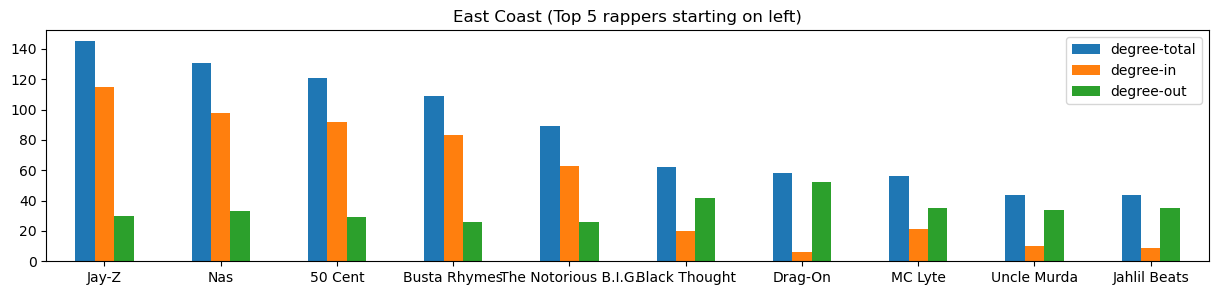

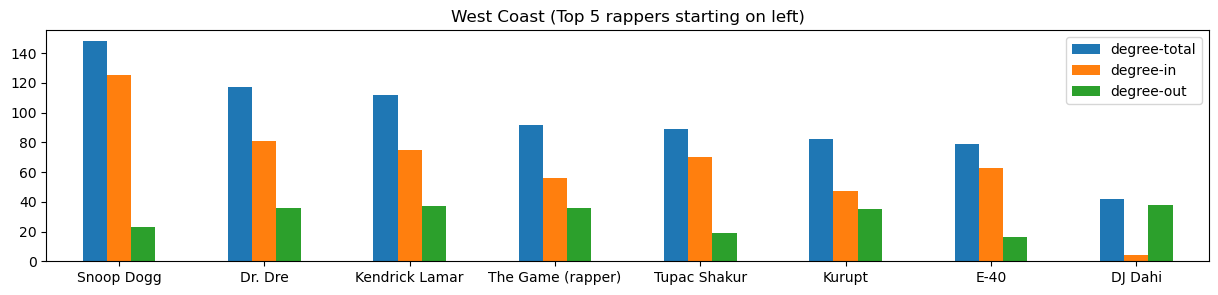

In [11]:
df_East.plot.bar(figsize=(15,3), rot=0, title="East Coast (Top 5 rappers starting on left)")
print("East Coast top rappers (5 best of in+out+ total degree):")
display(df_East)
print("West Coast top rappers (5 best of in+out+ total degree):")
display(df_West)
df_West.plot.bar(figsize=(15,3), rot=0, title="West Coast (Top 5 rappers starting on left)")

Observations:
* West coast rappers in+out+total are less -> the most connected, the ones more refferenced and the ones who refference more are the same ones more or less.
* Similar number of links (way of interacting) for west and east ones -> about music relationships context
* The degree in is usually similar to the total degree. Though, when reducing the rapper's connectivity, the out-degree keeps behaving the same way, while the degree-in is reduced. -> degree-out might follow a random pattern independent of popularity, while degree-in presents a hierarchy.

 * 1.a.6. Plot the in- and out-degree distributions for the whole network. 
   * Use axes that make sense for visualizing this particular distribution.
   * What do you observe? 
   * Give a pedagogical explaination of why the in-degree distribution is different from the out-degree distribution?


Text(0.5, 1.0, 'Out-degree distribution')

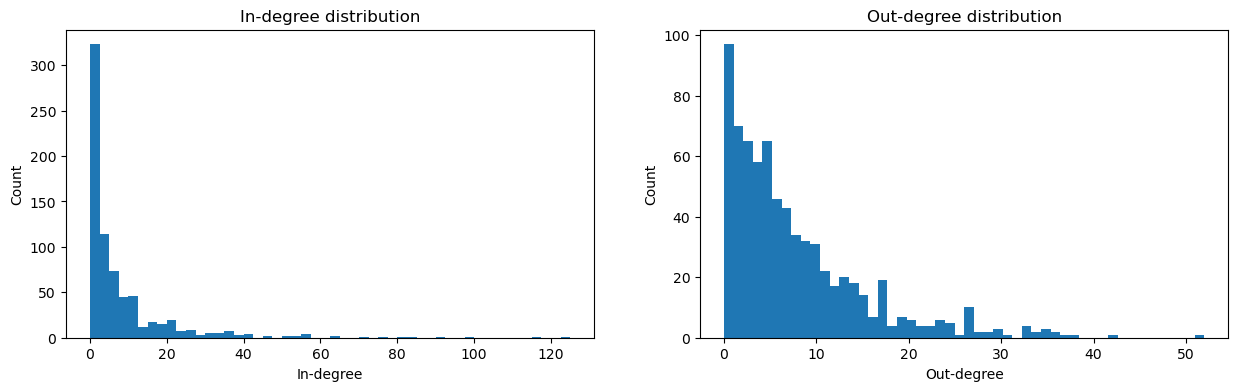

In [12]:
nbins1=50
plt.subplots(1,2,figsize=(15,4))

# Rappers (real) network

# In-degree distribution
plt.subplot(1,2,1)
in_degrees = [G_dir.in_degree(n) for n in G_dir.nodes()]
plt.hist(in_degrees, bins=nbins1,label="Real")
plt.xlabel("In-degree")
plt.ylabel("Count")
plt.title("In-degree distribution")

# Out-degree distribution
plt.subplot(1,2,2)
out_degrees = [G_dir.out_degree(n) for n in G_dir.nodes()]
plt.hist(out_degrees, bins=nbins1,label="Real")
plt.xlabel("Out-degree")
plt.ylabel("Count")
plt.title("Out-degree distribution")

* What it is observed:
    * The in-degree distribution is more concentrated around 0 in-degrees: most of the rappers get few refferences to them, since most of them are not very popular, only a few are, which reach high values of out-degree (more than 120). On the other hand, the out-degree follows a more equitative repartition of degrees, reaching lower values and being less extreme. This denotes that **out-degrees seem more randomly distributed, while in-degree is very hierarchical**.
* Why the in-degree distribution is different from the out-degree distribution:
    * The out-degree is about an individual rapper refferencing to other individuals, which doesn't really depend on how popular they are. That's why it makes sense it is kind of stochastic. Number of out-degrees varies more between individuals, being more evenly distributed, since each one has their own strategy and way of working with others, annd their own influences.
    * The in-degree is about others reffencing a rapper who influences them or whose song they use, so tend to cluster around influential and known rappers. The most popular rappers behave like hubs (scale-free), and most in-degrees are close to 0 (rarely refferenced by othres if you aren't popular )

If set axis to be loglog:

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


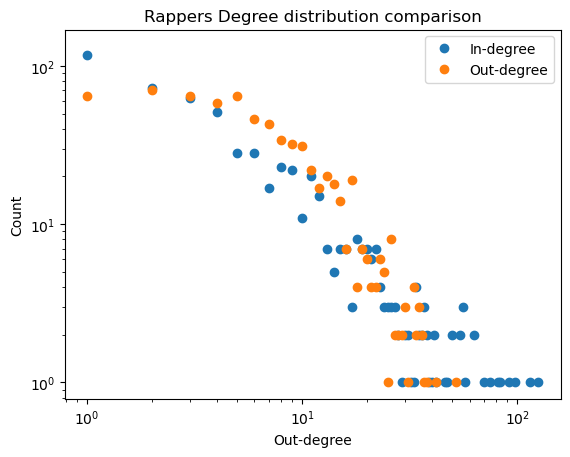

In [13]:
# In-degree distribution 
plt.figure()
in_degrees = [G_dir.in_degree(n) for n in G_dir.nodes()]
in_deg_freq = np.bincount(in_degrees)
in_deg_rank = np.arange(len(in_deg_freq))
plt.plot(in_deg_rank, in_deg_freq, "o", label="In-degree")
plt.xlabel("In-degree")
plt.ylabel("Count")
plt.xscale("log")
plt.yscale("log")

# Out-degree distribution
out_degrees = [G_dir.out_degree(n) for n in G_dir.nodes()]
out_deg_freq = np.bincount(out_degrees)
out_deg_rank = np.arange(len(out_deg_freq))
plt.plot(out_deg_rank, out_deg_freq, "o", label="Out-degree")
plt.xlabel("Out-degree")
plt.ylabel("Count")
plt.xscale("log")
plt.yscale("log")
plt.title("Rappers Degree distribution comparison")
plt.legend()

The in-degree log-log plot follows a really similar shape a scale-free network, while the out-degree one deviates. This denotes a clear different behaviour between the refferencing to others and being referenced.

 * 1a.7. Find the exponent (by using the `powerlaw` package) for the in- and out-degree distributions. What does it say about our network?

In [14]:
# Assuming 'in_degrees', 'out_degrees', and 'total_degrees' are your degree distributions
in_degree_values = list(dict(G_dir.in_degree()).values())
out_degree_values = list(dict(G_dir.out_degree()).values())
total_degree_values = in_degree_values+out_degree_values

in_degree_exponent = powerlaw.Fit(in_degree_values).alpha
out_degree_exponent = powerlaw.Fit(out_degree_values).alpha
total_degree_exponent = powerlaw.Fit(total_degree_values).alpha

print("In-degree exponent (γ):", round(in_degree_exponent,3))
print("Out-degree exponent (γ):", round(out_degree_exponent,3))
print("Total-degree exponent (γ):", round(total_degree_exponent,3))  

In-degree exponent (γ): 2.742
Out-degree exponent (γ): 12.016
Total-degree exponent (γ): 3.216


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
C:\Users\Sara\anaconda3\lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


* **In-degree exponent:** $ 2.7 \in (2,3)$. (Scale-free regime) Ultra-small world property shrinking average path: the network has a heavy-tailed distribution, with a stronger emphasis on hub nodes. Hubs radically reduce the path length.
* **Out-degree exponent:** $12 \gg 3$ (Small wold regime): Hubs are not sufficientlly large and numerous to have a significant impact. Random regime.

The referencing to other rappers (out degree), follows a random regime, there are fewer hub nodes, and most nodes have relatively similar out-degrees, so more or less rappers interact similarly, being decentralized.

The being-refferenced distribution (in-degree) denotes that there are nodes with high in-degrees, hubs, which play a significant role in the network's connectivity. Refferencing to a hub connects you closer to other nodes (makes sense, since if your tastes are close to certaing rapper, that will connect you with someone who also does)


 As the article [Wikipedias: Collaborative web-based encyclopedias as complex networks](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.74.016115) stated, $γ_{in}$ in Wikipedia usually display a similar behaviour around $ (2.15 \pm 0.13)$, this suits the result of this Notebook. The article also found that the output degree distribution doesn't express as much the power-law, and it's what was found too, since it follows a more random network behaviour.

 * 1a.8. Compare the two degree distributions two the degree distribution of a *random network* (undirected) with the same number of nodes and probability of connection *p*. Comment your results. \
 Note: Also will compare to a scale-free (Barabasi network) network.

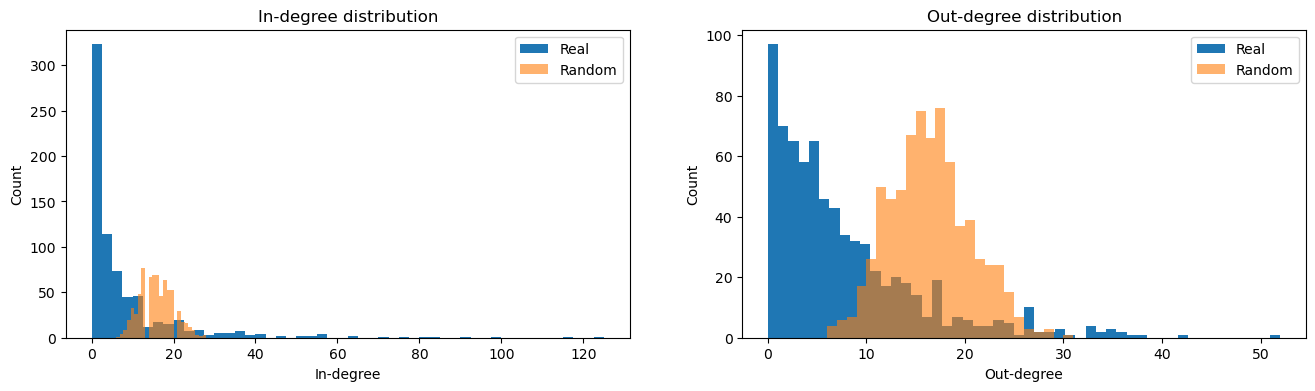

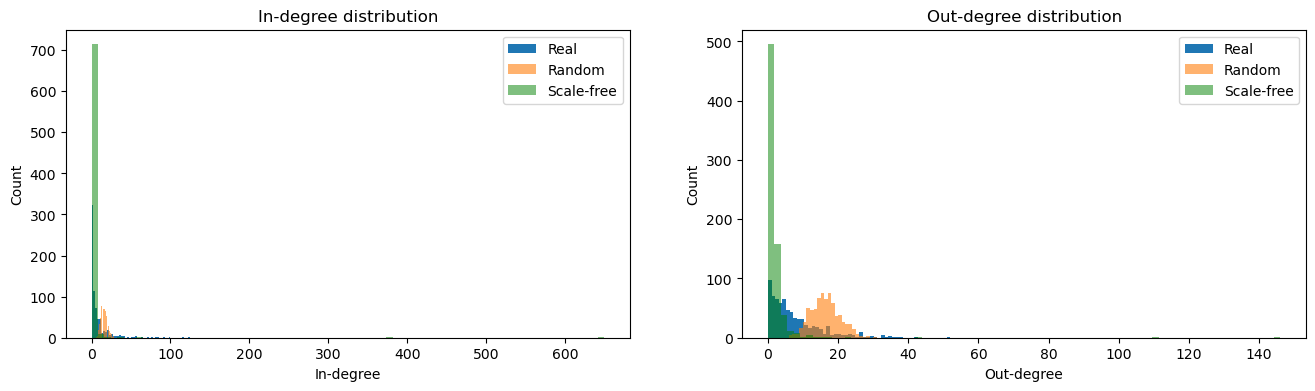

In [15]:
def plotDegEx1_6(loglog=False):
    nbins1=50
    nbins2=25
    plt.subplots(1,2,figsize=(16,4))

    # Rappers (real) network

    # In-degree distribution
    plt.subplot(1,2,1)
    in_degrees = [G_dir.in_degree(n) for n in G_dir.nodes()]
    plt.hist(in_degrees, bins=nbins1,label="Real")
    plt.xlabel("In-degree")
    plt.ylabel("Count")
    plt.title("In-degree distribution")

    # Out-degree distribution
    plt.subplot(1,2,2)
    out_degrees = [G_dir.out_degree(n) for n in G_dir.nodes()]
    plt.hist(out_degrees, bins=nbins1,label="Real")
    plt.xlabel("Out-degree")
    plt.ylabel("Count")
    plt.title("Out-degree distribution")

    # Random network with the same number of nodes and p (comparison purposes)

    p_ER = np.mean(list(dict(G_dir.degree()).values())) / (G_dir.number_of_nodes() - 1) #<k>=p(N-1)
    G_ER = nx.fast_gnp_random_graph(G_dir.number_of_nodes(), p=p_ER, directed=True, seed=1)

    # In-degree distribution
    plt.subplot(1,2,1)
    in_degrees = [G_ER.in_degree(n) for n in G_ER.nodes()]
    plt.hist(in_degrees, bins=nbins2,label="Random",alpha=0.6)
    plt.legend()

    # Out-degree distribution
    plt.subplot(1,2,2)
    out_degrees = [G_ER.out_degree(n) for n in G_ER.nodes()]
    plt.hist(out_degrees, bins=nbins2,label="Random",alpha=0.6)
    plt.legend()
    return

plotDegEx1_6()

# Scale-free network with the same number of nodes (comparison purposes )

plotDegEx1_6()
nbins3=80
G_SF= nx.scale_free_graph(G_dir.number_of_nodes(),seed=1) # returns directed barabasi_albert_graph

# In-degree distribution
plt.subplot(1,2,1)
in_degrees = [G_SF.in_degree(n) for n in G_SF.nodes()]
plt.hist(in_degrees, bins=nbins3,label="Scale-free",alpha=0.5,color="green")
plt.xlabel("In-degree")
plt.ylabel("Count")
plt.title("In-degree distribution")
plt.legend()

# Out-degree distribution
plt.subplot(1,2,2)
out_degrees = [G_SF.out_degree(n) for n in G_SF.nodes()]
plt.hist(out_degrees, bins=nbins3,label="Scale-free",alpha=0.5,color="green")
plt.xlabel("Out-degree")
plt.ylabel("Count")
plt.title("Out-degree distribution")

plt.legend()
plt.show()

The previous graphs are shown in linear axis for comparison purposes to a random network and a scale-free network. \
The upper two graphs comparte to a random one, giving a closer view, and the lower two graphs represent the three networks.

Both the in-degree and out-degree distributions are half-way between a random (poisson) and a scale-free network, though out-degree takes a more similar shape to random (more spread), and in-degree to scale-free (there are hubs).

If set axis to be loglog:

In [16]:
p_ER = np.mean(list(dict(G_dir.degree()).values())) / (G_dir.number_of_nodes() - 1) 
#<k>=p(N-1)
G_ER = nx.fast_gnp_random_graph(G_dir.number_of_nodes(), p=p_ER, directed=True)

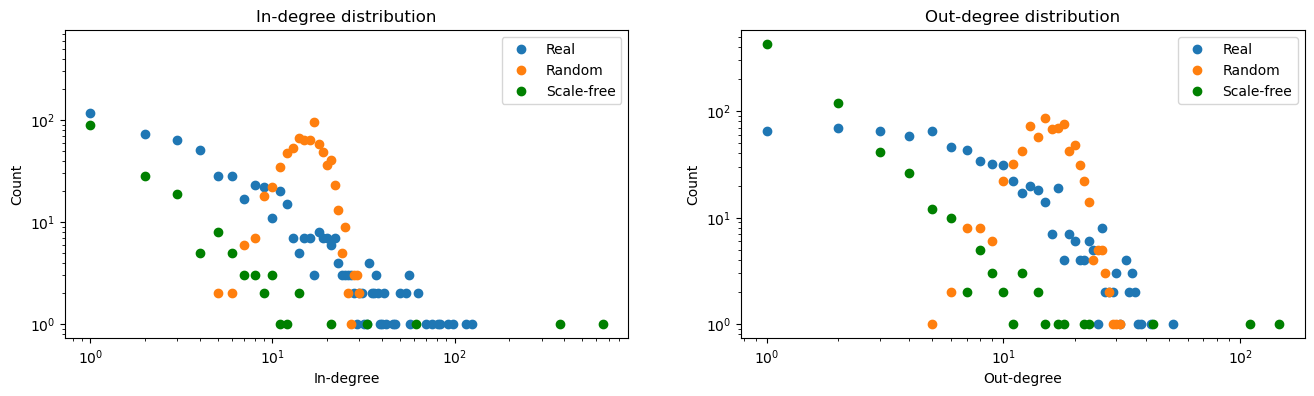

In [17]:
# Comparison to random and scale-free networks
# In-degree distribution
plt.subplots(1,2,figsize=(16,4))
plt.subplot(1,2,1)
in_degrees = [G_dir.in_degree(n) for n in G_dir.nodes()]
in_deg_freq = np.bincount(in_degrees)
in_deg_rank = np.arange(len(in_deg_freq))
plt.plot(in_deg_rank, in_deg_freq, "o", label="Real")
plt.xlabel("In-degree")
plt.ylabel("Count")
plt.xscale("log")
plt.yscale("log")
plt.title("In-degree distribution")

# Out-degree distribution
plt.subplot(1,2,2)
out_degrees = [G_dir.out_degree(n) for n in G_dir.nodes()]
out_deg_freq = np.bincount(out_degrees)
out_deg_rank = np.arange(len(out_deg_freq))
plt.plot(out_deg_rank, out_deg_freq, "o", label="Real")
plt.xlabel("Out-degree")
plt.ylabel("Count")
plt.xscale("log")
plt.yscale("log")
plt.title("Out-degree distribution")
plt.legend()

# Random network
in_degrees = [G_ER.in_degree(n) for n in G_ER.nodes()]
in_deg_freq = np.bincount(in_degrees)
in_deg_rank = np.arange(len(in_deg_freq))
plt.subplot(1,2,1)
plt.plot(in_deg_rank, in_deg_freq, "o", label="Random")
out_degrees = [G_ER.out_degree(n) for n in G_ER.nodes()]
out_deg_freq = np.bincount(out_degrees)
out_deg_rank = np.arange(len(out_deg_freq))
plt.subplot(1,2,2)
plt.plot(out_deg_rank, out_deg_freq, "o", label="Random")

# Scale-free network
in_degrees = [G_SF.in_degree(n) for n in G_SF.nodes()]
in_deg_freq = np.bincount(in_degrees)
in_deg_rank = np.arange(len(in_deg_freq))
plt.subplot(1,2,1)
plt.plot(in_deg_rank, in_deg_freq, "o", label="Scale-free",color="green")
plt.legend()
out_degrees = [G_SF.out_degree(n) for n in G_SF.nodes()]
out_deg_freq = np.bincount(out_degrees)
out_deg_rank = np.arange(len(out_deg_freq))
plt.subplot(1,2,2)
plt.plot(out_deg_rank, out_deg_freq, "o", label="Scale-free",color="green")
plt.legend()
plt.show()

From the log-log plot, the distribution of the degree for rappers, seem to be a scale-free (Barabasi) network for in-degree distribution (Scale free properties around hubs). \
The in-degree log-log plot follows a really similar shape to the simulated correspondent Scale-free network. 

## _Exercise 1b_: Visualization (see lecture 5 for more hints)

> * 1b.1. Create a nice visualization of the total (directed) network:
>   * Color nodes according to the role;
>   * Scale node-size according to degree;
>   * Get node positions based on either the Force Atlas 2 algorithm, or the built-in algorithms for networkX;
>   * Whatever else you feel like that would make the visualization nicer.
> * 1b.2. Describe the structure you observe. What useful information can you decipher from this?

 * 1b.1 Create a nice visualization of the total (directed) network:
   * Color nodes according to the role;
   * Scale node-size according to degree;
   * Get node positions based on either the Force Atlas 2 algorithm, or the built-in algorithms for networkX;
   * Whatever else you feel like that would make the visualization nicer.


<Figure size 2000x800 with 0 Axes>

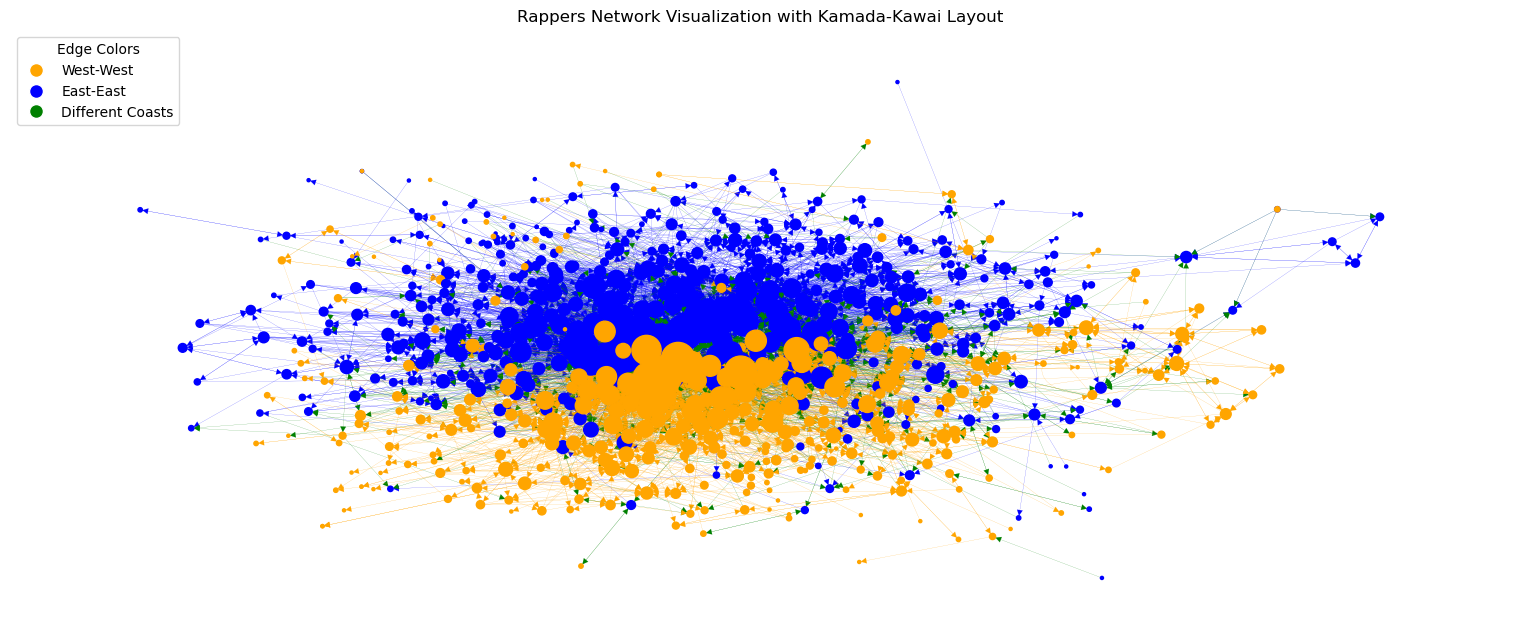

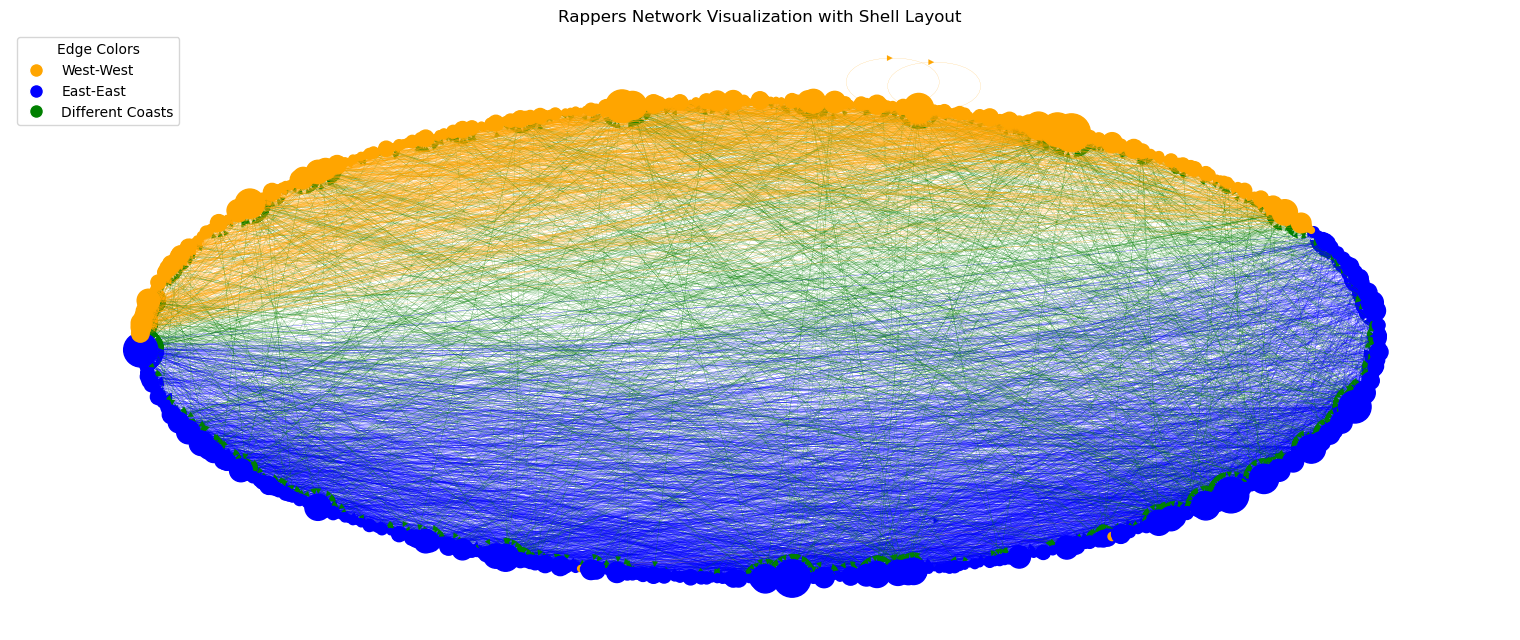

In [18]:
color_a="orange" #  between West
color_b="blue" # between East
color_c="green" # between Mixed

# Calculate node degrees
degrees = dict(G_dir.degree())

# Create a Networkx plot
plt.figure(figsize=(20,8))

# Define node and edge visualizations (code created in previous step)
node_color=[color_b if G_dir.nodes[n]["coast"] == "East" else color_a for n in G_dir.nodes]
node_size=[G_dir.degree(n)*5 for n in G_dir.nodes]
edge_colors = [color_a if G_dir.nodes[u]['coast'] == 'West' and G_dir.nodes[v]['coast'] == 'West'
               else color_b if G_dir.nodes[u]['coast'] == 'East' and G_dir.nodes[v]['coast'] == 'East'
               else color_c for u, v in G_dir.edges()]
pos=nx.kamada_kawai_layout(G_dir)#  Node positions


# Draw the network with specified attributes
plt.figure(figsize=(15,6))

nx.draw(G_dir, pos=pos ,with_labels=False, node_color=node_color, node_size=node_size, edge_color=edge_colors, alpha=1, width=0.1) #width=1.0

# Add a legend for edge colors
legend_labels = {'West-West': color_a, 'East-East': color_b, 'Different Coasts': color_c}
legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
                  for label, color in legend_labels.items()]
plt.legend(handles=legend_patches, title='Edge Colors', loc='upper left')

plt.axis('off')
plt.title("Rappers Network Visualization with Kamada-Kawai Layout")
plt.show()

# Shell layout
 
plt.figure(figsize=(15,6))
pos=nx.shell_layout(G_dir)
nx.draw(G_dir,pos=pos, with_labels=False, node_color=node_color, node_size=node_size, edge_color=edge_colors, alpha=1, width=0.1)
plt.legend(handles=legend_patches, title='Edge Colors', loc='upper left')
plt.axis('off')
plt.title("Rappers Network Visualization with Shell Layout")

plt.show()

100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:09<00:00, 66.57it/s]


BarnesHut Approximation  took  0.98  seconds
Repulsion forces  took  7.52  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.11  seconds
AdjustSpeedAndApplyForces step  took  0.16  seconds


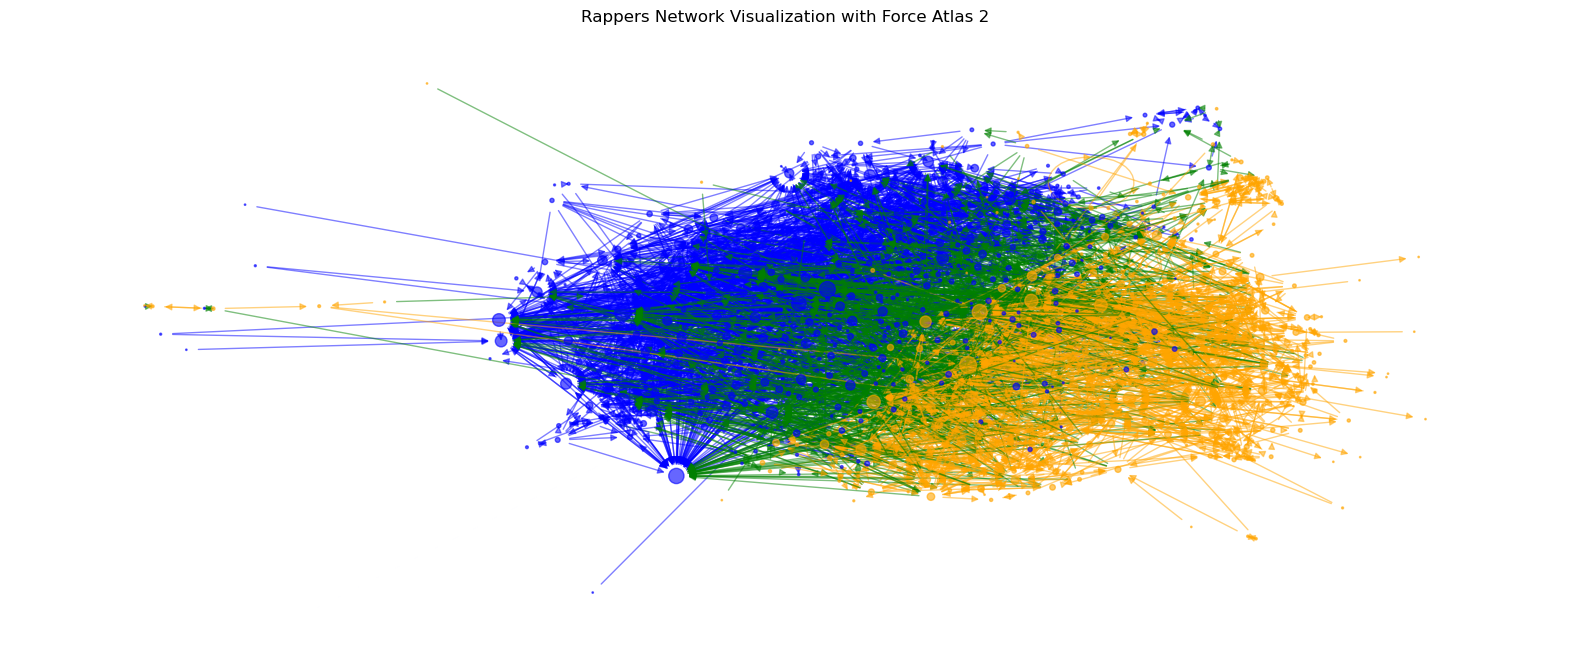

In [19]:
# other plots for better view - Undirected_Graph View:
G_undir = G_dir.copy().to_undirected()

# Create Force Atlas 2 layout
forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=True,  # Dissuade hubs: Distributes attraction along outbound edges. Hubs attract less and thus are pushed to the borders
    linLogMode=False,  # NOT IMPLEMENTED
    adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
    edgeWeightInfluence=1.0, # How much influence give to the edges weight. 0 is "no influence" and 1 is "normal"
    # Performance
    jitterTolerance=1.0,  # Tolerance. How much swinging you allow. Above 1 discouraged. Lower gives less speed and more precision
    barnesHutOptimize=True, # Barnes Hut optimization, n2 complexity to n.ln(n)
    barnesHutTheta=1.2,
    multiThreaded=False,  # NOT IMPLEMENTED
    # Tuning
    scalingRatio=10.0, # How much repulsion you want. More makes a more sparse graph
    strongGravityMode=False, # A stronger gravity view
    gravity=1, # Attracts nodes to the center. Prevents islands from drifting away
    # Log
    verbose=True) # Shows a progressbar of iterations completed. Also, shows time taken for different force computations
pos = forceatlas2.forceatlas2_networkx_layout(G_undir, pos=None, iterations=600) # If done from G_dir, poor display.

# Define node and edge visualizations (code created in previous step)
node_color=[color_b if G_dir.nodes[n]["coast"] == "East" else color_a for n in G_dir.nodes]
node_size=[G_dir.degree(n) for n in G_dir.nodes]
edge_colors = [color_a if G_dir.nodes[u]['coast'] == 'West' and G_dir.nodes[v]['coast'] == 'West'
               else color_b if G_dir.nodes[u]['coast'] == 'East' and G_dir.nodes[v]['coast'] == 'East'
               else color_c for u, v in G_dir.edges()]

# Draw nodes and edges
plt.figure(figsize=(20,8))
nx.draw_networkx_nodes(G_dir, pos, node_color=node_color, node_size=node_size, alpha=0.6)
nx.draw_networkx_edges(G_dir, pos, edge_color=edge_colors, width=1, alpha=0.5) # alpha is the transparency

plt.axis('off')
plt.title("Rappers Network Visualization with Force Atlas 2")
plt.show()

 * 1b.2. Describe the structure you observe. What useful information can you decipher from this?

    * Nodes with a privileged position in the network.
        * Hubs: biggest ones, when not in shell display, tend to be represented in the center, due to all their connections.
        * Some nodes (See kamada_kawai_layout representation) on the periphery have only in-degree, they are refferenced but have no other connection. Will display the kamada_kawai_layout again in the next cell, but with labels, to investigate who they are.
        
    * Chains of connected nodes are easier to see in the shell representation. 
        * There exist a lot of green links (West-Coast), interconnecting all the rappers in the network.
        * Hubs (big nodes) seem to have more proportion of green links (from the other coast) getting into them.
        * Hubs (big nodes) often seem to be inmediatly connected to other hubs or medium ones (not to small ones).

    * Interesting groups of nodes:
        * Usually rappers connect mostly to their own coast mates, that's why orange + blue links color a larger surface than green ones.
        * Some rappes drive away from the hubs, and create small components, generally with rappers from the same coast.


In [20]:
# pos=nx.kamada_kawai_layout(G_dir)#  Node positions
# plt.figure(figsize=(15,6))
# nx.draw(G_dir, pos=pos ,with_labels=True, node_color=node_color, node_size=node_size, edge_color=edge_colors, alpha=1, width=0.1) #width=1.0
# legend_labels = {'West-West': color_a, 'East-East': color_b, 'Different Coasts': color_c}
# legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
#                   for label, color in legend_labels.items()]
# plt.legend(handles=legend_patches, title='Edge Colors', loc='upper left')
# plt.axis('off')
# plt.title("Rappers Network Visualization with labels")
# plt.show()
# # rappers that only have 1 dregree-in and 0 degree-out
print("Rappers that only have 1 dregree-in and 0 degree-out:")
Rappers1in0out=[]
for n in G_dir.nodes():
    if G_dir.in_degree(n)==1 and G_dir.out_degree(n)==0:
        Rappers1in0out.append(n)
print(Rappers1in0out)

Rappers that only have 1 dregree-in and 0 degree-out:
['Cazwell', 'Louis Logic', 'Ahmad (rapper)', 'Aminé (rapper)', 'Beeda Weeda', "Captain Save 'Em", 'Daddy X', 'DB Tha General', 'Dubb 20', 'G-Nut', 'Killa Keise', 'King Lil G', 'Mr. Skrillz', 'Mugzi', 'Skee-Lo', 'Stressmatic', 'Tone Loc', 'V-White']


Examples of names on the periphery, that only have one degree and it is in: "Cazwell", "Louis Logic", "Ahmad (rapper)","Aminé (rapper)",...

The hypothesis for this, is that they are not tighly related to rap, they someway have crossed path, but, looking at their Wikipedia pages,seems they are focused on other styles that relate, like hip-hop, or non-strictly-focused on music careers. In fact, if done ctrl+F in their pages with "rap ", it is not directly mentioned in their pages.

# Part 2: Word-clouds

Create your own version of the word-clouds (from lecture 7). For this exercise we assume you know how to download and clean text from rappers' Wikipedia pages.

Here's what you need to do:
> * Create a word-cloud for each coast according to the novel TF-TR method. Feel free to make it as fancy as you like. Explain your process and comment on your results.
> * For each coast, what are the 5 words with the highest TR scores? Comment on your result.

**Keep the wiki text files in same directory**

Firstly the term frequency (TF) for each of the wikipages are calculated. This is done by first collecting all text, removing stopwords and count the remaining words. This is done for both the West and East coast rappers. 

In [157]:
#folder = folder with txt files

def TF(folder, remove_stopwords):
    directory = os.getcwd() + folder
    wiki_text = []
    for filename in os.listdir(directory):
        if filename.endswith('.txt'):
            words = re.findall(r'\w+', open(directory + filename, encoding="utf-8").read().lower())
            wiki_text.append(words)

            
    flat_text = []
    if remove_stopwords == True: 
        stop_words = set(stopwords.words('english'))
        stop_words.add('also')
        for sublist in wiki_text:
            for item in sublist: 
                if item not in stop_words:
                    flat_text.append(item)

    else:           
        for sublist in wiki_text:
            for item in sublist:
                flat_text.append(item)

    TF_list = Counter(flat_text).most_common()
    return TF_list



In [158]:
# The two lists of word counts
EC_TF = TF('\\eastcoasttexts\\', remove_stopwords=True)
WC_TF = TF('\\westcoasttexts\\', remove_stopwords=True)

#### Calculate the weight of the words
Now the weight of the words are calculated by the formulars

$$w_{t}^{(w)} = \frac{\textrm{TF}^{(w)}_t}{ \textrm{TF}^{(e)}_t + c}, \qquad \textrm{and} \qquad w_{t}^{(e)} = \frac{\textrm{TF}^{(e)}_t}{ \textrm{TF}^{(w)}_t + c}. $$

In the same go function, the TF-TR are calculated by multiplying the weight by the term frequency, $\textrm{TF}^{(u)}_t \times w_{t}^{(u)}$. The function return a list of the calculated TF-TR. 

In [164]:
def TF_TR(list1, list2):
    TF_TR_list = []
    TR_list = []
    TF_TR = 0
    c=0.000000001
    for word1 in range(len(list1)):
        for word2 in range(len(list2)):
            if list1[word1][0] == list2[word2][0]:
                w = (list1[word1][1])/(list2[word2][1])
                TR_list.append(tuple((list1[word1][0], w)))
                TFTR = w*list1[word1][1]
                TF_TR_list.append(tuple((list1[word1][0], TFTR)))
    TF_TR_list.sort(key = lambda x: x[1], reverse=True) 
    return TF_TR_list, TR_list

In [165]:
# Two lists of TF-TR
WC_TFTR, WC_TR = TF_TR(WC_TF, EC_TF)
EC_TFTR, EC_TR = TF_TR(EC_TF, WC_TF)

KeyboardInterrupt: 

In [ ]:
print(f'The top five words of the west coast are  {WC_TR[0:5]}')
print(f'The top fice words of the east coast are {EC_TR[0:5]}')

We see that the top five words have common words for the two groups. This makes great sense, since they are Album, released and music and those words will be present in most music related wikipages. 

#### Create wordclouds
Now the strings for the wordclouds are prepared. This is done by appeding the words as many time as their TF-TR number to a list and converting it to a string with spaces. 

In [26]:
WordCloud_EC = []
WordCloud_WC = []
for elem in EC_TFTR:
    temp = (elem[0] + ' ')*int(elem[1])
    WordCloud_EC.append(temp)
EC_string = " ".join(WordCloud_EC)

for elem in WC_TFTR:
    temp = (elem[0] + ' ')*int(elem[1])
    WordCloud_WC.append(temp)
WC_string = " ".join(WordCloud_WC)

Now the data is ready to make the two wordclouds. And ofcourse, the wordclouds are formed by two of the most famous west coast and east coast rappers; Tupac and The Notorious B.I.G. 

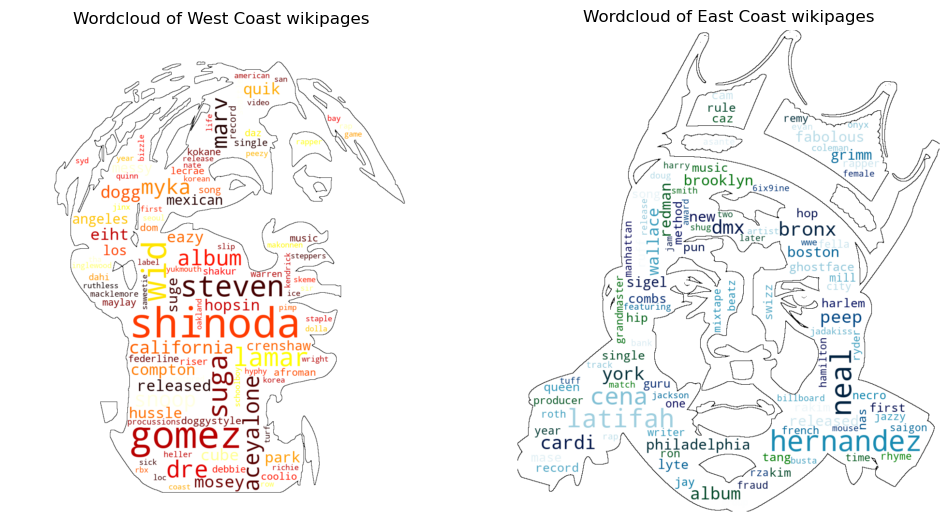

In [115]:
# Generate masks and wordclouds
west_mask = np.array(Image.open("tupac2.png"))
wordcloud = WordCloud(collocations = False, background_color='white', colormap = "hot", max_words=100, min_word_length=3, mask=west_mask,contour_color='black',contour_width=1).generate(WC_string)

east_mask = np.array(Image.open("nbig2.png"))
wordcloud2 = WordCloud(collocations = False, background_color='white', colormap = "ocean", max_words=100, min_word_length=3, mask=east_mask,contour_color='black',contour_width=1).generate(EC_string)


#Plot the clouds
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,12))

# Display the generated image:
ax1.imshow(wordcloud, interpolation='bilinear')
ax1.set_title("Wordcloud of West Coast wikipages")
ax1.axis("off")

ax2.imshow(wordcloud2, interpolation='bilinear')
ax2.set_title("Wordcloud of East Coast wikipages")
ax2.axis("off")

plt.show()

# Part 3: Communities



### Modularity

Modularity is the measure of the combination or separation of a system. With a high modularity comes a highly combined community. We calculate the modularity for each community and sum over to get the modularity for the entire system. The expected connectivity inside the partition is subtracted from the density of links in the community to find the modularity. 

#### Create undirected network
Before the community analysis can begin, an undirected version of the network is created. All of this is done in the cell below. It takes approximately 5 minutes to run the cell and is only needed if you want to inspect the code.  

In [28]:
# load WestCoastRappers.csv and EastCoastRappers.csv 
EastCoast = pd.read_csv("EastCoastRappers.csv")
WestCoast = pd.read_csv("WestCoastRappers.csv")

# List rappers
WC_rappers = list(WestCoast.WikipediaPageName)
EC_rappers = list(EastCoast.WikipediaPageName)
all_rappers = EC_rappers + WC_rappers

#Create an undirected graph
G = nx.Graph()

#Add one node for alle rappers
for node in range(len(WC_rappers)):
    G.add_node(WC_rappers[node], coast = "west Coast")
    
for node in range(len(EC_rappers)):
    G.add_node(EC_rappers[node], coast= "East Coast")
    
    
# Create undirected graph
for rapper in range(len(all_rappers)):
    baseurl = "https://en.wikipedia.org/w/api.php?"
    #Get the wiki text from rappers
    params = {
    "action": "query", 
    "prop": "revisions",
    "rvprop": "content", 
    "format": "json", 
    "titles": all_rappers[rapper]}
    wikitext_all = requests.get(baseurl, params=params)
    wikijson_all = wikitext_all.json()
    
    id_all = list(wikijson_all['query']['pages'].keys())
    wikitext_all = wikijson_all['query']['pages'][id_all[0]]['revisions'][0]['*']

    #Get the hyperlinks from wikipage
    temp_links = re.findall(r'\[\[(.*?)\]\]', wikitext_all)

    # Clean list from "double" links i.g. 'Bad Azz (rapper)|Bad Azz' 
    for link in range(len(temp_links)):
        temp_links[link] = re.sub('\|.*$', '', temp_links[link])
        
        #discard link if it is not a rapper
        links = []
        if temp_links[link] in (all_rappers):
            links.append(temp_links[link])
        
        # Add edge from rapper to wiki-link
        for link in range(len(links)):
            G.add_edge(all_rappers[rapper], links[link])
            
# Take out isolated ones
isolated_nodes = [node for node in G.nodes() if G.degree(node) == 0 ]
G.remove_nodes_from(isolated_nodes)


print(f'The undirected network includes {G.number_of_nodes()} nodes and {G.number_of_edges()} edges')

The undirected network includes 730 nodes and 4955 edges


As seen from the result, the undirected graph has 4955 edges till the 730 nodes. It makes sense that the number of links are less than for the directed graph, that there are some double links due to wikipages pointing to eachother in the directed graph. 

### Find communities in the network


To detect communities in the network, the Louvain algorithm is used. To not confuse the algorithm, the networks are split up into two, based on their coasts. After that, the partitions are combined into a single partioning of the entire network. 

The Louivan algorithm is a greedy algorithm, which tries to maximize modularity. The algorithm is clustering the nodes traversing over all nodes, searching for the highest modularity, moving nodes araound different clusters until no movement of nodes can provide a higher modularity. 

The first step is to partition network into two parts; east and west coast rappers. Again nodes without degree=0 is removed. 

In [126]:
# Partition the rappers into two communities
WC_com = set()
EC_com = set()

for i in G.nodes():
    if G.nodes[i]['coast'] == 'west Coast':
        WC_com.add(i)
    if G.nodes[i]['coast'] == 'East Coast': 
        EC_com.add(i)
        
# Create subgraphs of the two communities
WC_G = G.subgraph(WC_com)
EC_G = G.subgraph(EC_com)

#Unfreeze subgraphs
WC_G = nx.Graph(WC_G)
EC_G = nx.Graph(EC_G)

# Remove isolated nodes in subgraphs
isolated_nodes = [node for node in EC_G.nodes() if EC_G.degree(node) == 0 ]
EC_G.remove_nodes_from(isolated_nodes)

isolated_nodes = [node for node in WC_G.nodes() if WC_G.degree(node) == 0 ]
WC_G.remove_nodes_from(isolated_nodes)

Next, the three networks are partitioned using the Louvain algorithm. The algorithm assigns a community to every node, in the way described earlier. 

In [161]:
#Use louvain algorithm to partition 
partition_east = community.best_partition(EC_G)
partition_west = community.best_partition(WC_G)
partition = community.best_partition(G)


for i in range(len(partition)):
    if partition.key() is in WC_rappers: 
        

{'03 Greedo': 0,
 '24kGoldn': 0,
 '40 Glocc': 1,
 'DJ A-Tron': 0,
 'Ab-Soul': 0,
 'Abstract Rude': 4,
 'Aceyalone': 4,
 'Afroman': 1,
 'Ahmad (rapper)': 2,
 "Ak'Sent": 4,
 'The Alchemist (musician)': 5,
 'AMG (rapper)': 1,
 'Aminé (rapper)': 6,
 'Antwon': 5,
 'B-Legit': 1,
 'B-Real': 1,
 'B.G. Knocc Out': 1,
 'Show Banga': 0,
 'Ant Banks': 1,
 'Sho Baraka': 7,
 'Becky G': 8,
 'Beeda Weeda': 1,
 'Beefy (rapper)': 4,
 'Berner (rapper)': 1,
 'Big B (rapper)': 1,
 'Big Dave (rapper)': 1,
 'Big Ed (rapper)': 1,
 'Big Fase 100': 1,
 'Bizzle': 7,
 'Aloe Blacc': 5,
 'Guerilla Black': 1,
 'Nissim Black': 6,
 'Toni Blackman': 6,
 'Blueface': 0,
 'Blxst': 0,
 'Bones (rapper)': 8,
 'Braille (musician)': 6,
 'Buddy (rapper)': 0,
 'Busdriver': 4,
 'Scott Caan': 5,
 'Sway Calloway': 6,
 'Nick Cannon': 8,
 "Captain Save 'Em": 1,
 'Clyde Carson': 1,
 'Celestaphone': 6,
 'DJ Cheapshot': 5,
 'Tha Chill': 1,
 'Shawn Chrystopher': 0,
 'Chanel West Coast': 1,
 'Conceit (rapper)': 6,
 'Coolio': 1,
 'Cozz': 0

To get the modularity of the network, with the partition done per coast, the two partition dictionaries are merged together. 

In [128]:
# Merging the two dictionaries
partition_east_west = {}
for key, value in partition_east.items():
    partition_east_west[key] = value +  max(partition_west.values())+1 
partition_east_west.update(partition_west)

print(f'The {len(partition_east_west)} nodes are partitioned in {set(partition_east_west.values())} communities')

The 711 nodes are partitioned in {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18} communities


Here it is noted that the combined partitions only consists of 711 nodes, while the original network consists of 730. Therefore the remaining 19 nodes are taken out before calculating the modularity. 

In [129]:
#Make list of rappers in combined partition, create subgraph and unfreeze it. 
rap = list(partition_east_west.keys())
EC_WC_G = G.subgraph(rap)
EC_WC_G = nx.Graph(EC_WC_G)

To visualize the networks, they are drawn with networkX. It can be a bit dificult to see, but it does look like there are some groupings in the graphs. 

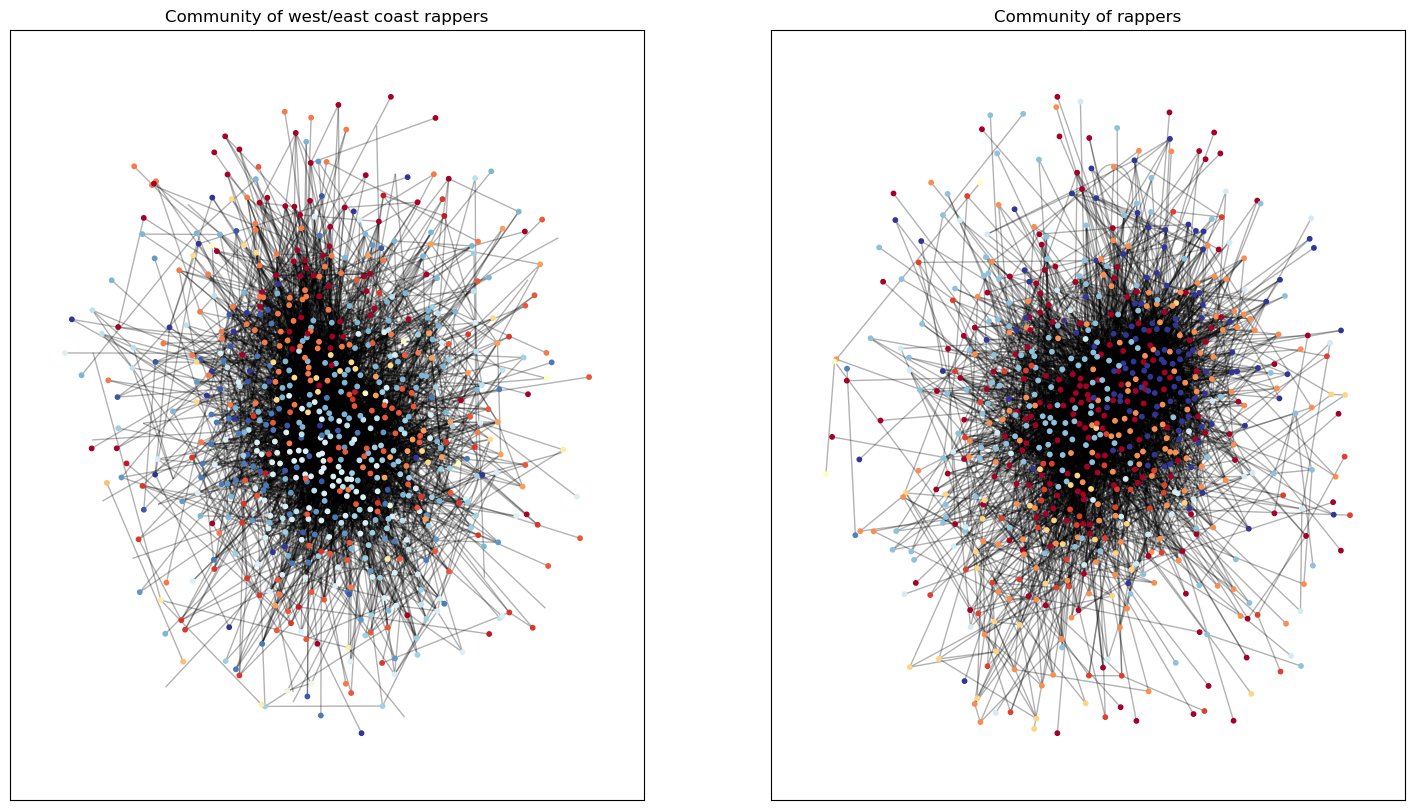

In [130]:
fig, ax = plt.subplots(1, 2, figsize=(18, 10))

ax[0].set_title("Community of west/east coast rappers")
pos = nx.spring_layout(EC_WC_G, k=0.3, iterations=50)
nx.draw_networkx_nodes(EC_WC_G, pos, partition_east_west.keys(), node_size=10, cmap=plt.cm.RdYlBu, node_color=list(partition_east_west.values()), ax=ax[0])
nx.draw_networkx_edges(EC_WC_G, pos, alpha=0.3, ax=ax[0])


ax[1].set_title("Community of rappers")
pos = nx.spring_layout(G, k=0.3, iterations=50)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=10, cmap=plt.cm.RdYlBu, node_color=list(partition.values()), ax=ax[1])
nx.draw_networkx_edges(G, pos, alpha=0.3, ax=ax[1])

plt.show()


To investigate the partitions, the communities are loaded into dictionaries containing the node-labels for each community. Then the sizes of the different communities are calculated. 

In [137]:
#Divide communities in a dictionary
community_dist_west = {}
for i in range(len(set(partition_west.values()))):
    community_dist_west['nodes_in_community'+str(i)] = [node for node,community in partition_west.items() if community == i]

community_dist_east = {}
for i in range(len(set(partition_east.values()))):
    community_dist_east['nodes_in_community'+str(i)] = [node for node,community in partition_east.items() if community == i]

community_dist_east_west = {}
for i in range(len(set(partition_east_west.values()))):
    community_dist_east_west['nodes_in_community'+str(i)] = [node for node,community in partition_east_west.items() if community == i]
    
community_dist = {}
for i in range(len(set(partition.values()))):
    community_dist['nodes_in_community'+str(i)] = [node for node,community in partition.items() if community == i]

#Calculate sizes of communities
com_size = {key:len(value) for key,value in community_dist.items()}
com_size_east = {key:len(value) for key,value in community_dist_east.items()}
com_size_west = {key:len(value) for key,value in community_dist_west.items()}
com_size_east_west = {key:len(value) for key,value in community_dist_east_west.items()}

To visualize the aspects of the networks, the size of the communities are plottet. 

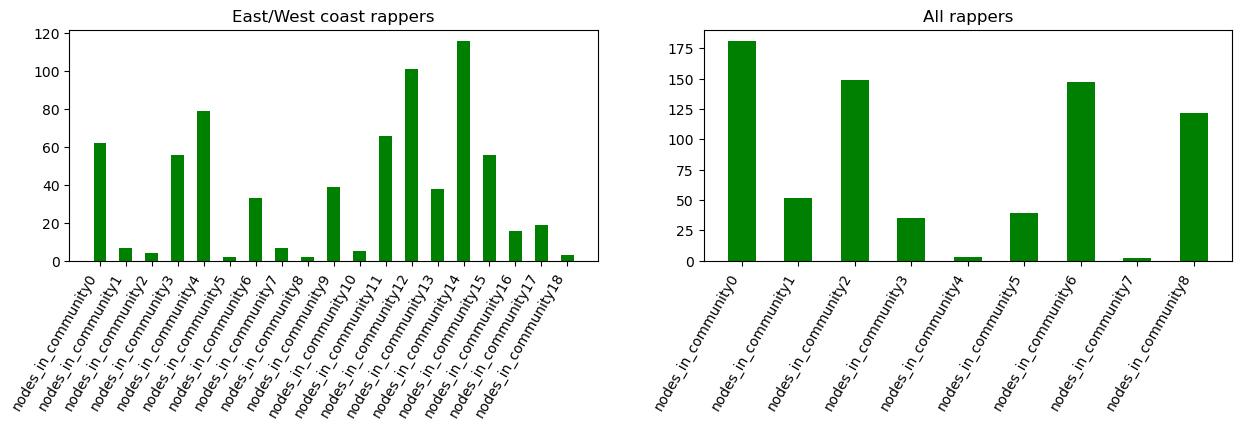

In [132]:
#Plot the community distribution from the different graphs
fig, ax = plt.subplots(1, 2, figsize=(15, 3))

ax[0].set_title("East/West coast rappers")
ax[0].bar(com_size_east_west.keys(), com_size_east_west.values(), width=0.5, color='g')

ax[1].set_title("All rappers")
ax[1].bar(com_size.keys(), com_size.values(), width=0.5, color='g')

plt.setp(ax[0].get_xticklabels() + ax[1].get_xticklabels(), rotation=60, ha='right')

plt.show()

Lastly, the modularities calculated and held up against eachother. ADD BOTH COMMUNITYSET FROM EAST AND WEST AND CALCULATE NEW MODULARITY

In [139]:
print(f'The network of all rappers ({G.number_of_nodes()} nodes and {G.number_of_edges()} edges) is partitioned in {len(com_size.keys())} communities with a modularity: {nx.community.modularity(G, community_dist.values()):.3f}')
print(f'The combined network of all rappers ({EC_WC_G.number_of_nodes()} nodes and {EC_WC_G.number_of_edges()} edges) is partitioned in {len(com_size_east_west.keys())} communities with a modularity: {nx.community.modularity(EC_WC_G, community_dist_east_west.values()):.3f}')

The network of all rappers (730 nodes and 4955 edges) is partitioned in 9 communities with a modularity: 0.399
The combined network of all rappers (711 nodes and 4931 edges) is partitioned in 19 communities with a modularity: 0.353


We get a better split between all rappers, than we do for only one group of rappers. This tell us that there are better communities between the mixed group of rappers that in only the west/east coast. {MAYBE CALCULATE HOW MANNY EACH/WEST ARE IN THE DIFFERENT COMMUNITIES IN THE TOTAL}

In [140]:
print(f'The network of the West Coast ({WC_G.number_of_nodes()} nodes and {WC_G.number_of_edges()} edges) is partitioned in {len(com_size_west.keys())} communities with a modularity: {nx.community.modularity(WC_G, community_dist_west.values()):.3f}')
print(f'The network of the East Coast ({EC_G.number_of_nodes()} nodes and {EC_G.number_of_edges()} edges) is partitioned in {len(com_size_east.keys())} communities with a modularity: {nx.community.modularity(EC_G, community_dist_east.values()):.3f}')

The network of the West Coast (296 nodes and 1346 edges) is partitioned in 10 communities with a modularity: 0.427
The network of the East Coast (415 nodes and 2503 edges) is partitioned in 9 communities with a modularity: 0.350


### Modularity of two communities
Now we'll partition the rappers into two communities, based on which coast they represent and check the modularity of this partition. 


In [35]:
# Partition the rappers into two communities
WC_com = set()
EC_com = set()

for i in G.nodes():
    if G.nodes[i]['coast'] == 'west Coast':
        WC_com.add(i)
    if G.nodes[i]['coast'] == 'East Coast': 
        EC_com.add(i)

In [36]:
#Modularity in the created community
print(f'Modularity of the partition is {nx.community.modularity(G, [WC_com, EC_com]):.3f}')

Modularity of the partition is 0.250


The coasts manually splitted in two communities does not give a very good modularity. This makes sense, since there are a lot of link between rappers from each groups. MORE DETAILED COMMENT HERE

# Part 4: Sentiment of communities

In this part we are using the LabMT wordlist approach to 
> * 4.1 find out what are the 10 rappers with happiest and saddest pages
> * 4.2 compute the sentiment of each coast (The coasts are seen as communities)

## 4.1 Happiest and Saddest pages

To discover what are the happiest and saddest rapper pages, we first need to calculate and store sentiment for every rapper. Let's start by checking how our sentiment data looks like.

In [83]:
with open('Data_Set_S1.txt', 'r', encoding='utf8') as score_file:
    for line in score_file:
        print(line.strip())

labMIT-1.0.txt
language assessment by Mechanical Turk 1.0

word	happiness_rank	happiness_average	happiness_standard_deviation	twitter_rank	google_rank	nyt_rank	lyrics_rank
laughter	1	8.50	0.9313	3600	--	--	1728
happiness	2	8.44	0.9723	1853	2458	--	1230
love	3	8.42	1.1082	25	317	328	23
happy	4	8.30	0.9949	65	1372	1313	375
laughed	5	8.26	1.1572	3334	3542	--	2332
laugh	6	8.22	1.3746	1002	3998	4488	647
laughing	7	8.20	1.1066	1579	--	--	1122
excellent	8	8.18	1.1008	1496	1756	3155	--
laughs	9	8.18	1.1551	3554	--	--	2856
joy	10	8.16	1.0568	988	2336	2723	809
successful	11	8.16	1.0759	2176	1198	1565	--
win	12	8.12	1.0812	154	3031	776	694
rainbow	13	8.10	0.9949	2726	--	--	1723
smile	14	8.10	1.0152	925	2666	2898	349
won	15	8.10	1.2164	810	1167	439	1493
pleasure	16	8.08	0.9655	1497	1526	4253	1398
smiled	17	8.08	1.0660	--	3537	--	2248
rainbows	18	8.06	1.3603	--	--	--	4216
winning	19	8.04	1.0490	1876	--	1426	3646
celebration	20	8.02	1.5318	3306	--	2762	4070
enjoyed	21	8.02	1.5318	1530	2908	3502	--
h

### Calculate and store sentiments

Now we can use the folders that have text files of the wikipedia pages, extract the words and match them with the right row. Then we can calculate the average sentiment score based on the "happiness_average" values.

In [84]:
# Load sentiment scores into a dictionary
scores = {}
with open('Data_Set_S1.txt', 'r', encoding='utf8') as score_file:
    line_count = 0
    for line in score_file:
        line_count += 1
        if line_count <= 4:
            continue  # Skip the first 4 lines (don't have happiness_average value)

        columns = line.strip().split('\t')
        if len(columns) >= 2:
            word = columns[0].lower()
            score = float(columns[2])
            scores[word] = score

result = []
root_folders = ['eastcoasttexts', 'westcoasttexts']

# Prepare lists to calculate average sentiment scores for East Coast and West Coast later
east_coast_scores = []
west_coast_scores = []

# Process text files and calculate average sentiment
for root_folder in root_folders:
    for rapper_file in os.listdir(root_folder):
        if rapper_file.endswith(".txt"):
            rapper_path = os.path.join(root_folder, rapper_file)

            with open(rapper_path, 'r', encoding='utf8') as rapper_text:
                text = rapper_text.read()
                words = re.findall(r'\b[a-zA-Z]+\b', text)

            # Calculate average sentiment for the document
            valid_words = [word for word in words if word.lower() in scores]
            word_scores = [scores[word.lower()] for word in valid_words]

            if len(word_scores) > 0:
                average_score = round(sum(word_scores) / len(word_scores), 3)
                
            else:
                average_score = 0  # Set the average score to 0 if there are no valid words
                
            # Determine the coast based on the file location
            coast = "East Coast" if "eastcoasttexts" in rapper_path.lower() else "West Coast"

            if coast == "East Coast":
                east_coast_scores.append(average_score)
            elif coast == "West Coast":
                west_coast_scores.append(average_score)

            # Store rapper's name and average score
            rapper_name = os.path.splitext(rapper_file)[0]
            result.append((rapper_name, average_score))


# Create a list of (rapper, average score) pairs
for rapper, average_score in result:
    print(rapper,average_score)

22Gz 5.419
38_Spesh 5.576
50_Cent 5.426
60_Second_Assassin_(rapper) 5.581
6ix9ine 5.327
88-Keys 5.546
9th_Prince 5.335
Action_Bronson 5.613
Adeem_(rapper) 5.518
Aesop_Rock 5.52
Afrika_Bambaataa 5.48
Afu-Ra 5.553
Akir 5.582
Akrobatik 5.393
Alias_(musician) 5.488
Ali_Shaheed_Muhammad 5.532
Ali_Vegas 5.615
Alrad_Lewis 5.589
Al_Sherrod_Lambert 5.666
Amil 5.503
Andre_Harrell 5.532
Andy_Mineo 5.559
Antoinette_(rapper) 5.685
Aone_Beats 5.582
Apache_(rapper) 5.37
Apani_B._Fly 5.575
Apathy_(rapper) 5.435
AR-Ab 5.257
AraabMuzik 5.544
Arkatech_Beatz 5.489
ASAP_Ferg 5.493
ASAP_Nast 5.424
ASAP_Rocky 5.385
ASAP_Twelvyy 5.479
Asheru 5.634
Asher_Roth 5.517
Awkwafina 5.682
Azealia_Banks 5.509
AZ_(rapper) 5.458
B._Dolan 5.445
Bahamadia 5.722
Beanie_Sigel 5.327
Beedie_(rapper) 5.559
Benny_the_Butcher 5.387
Benzino 5.304
Big_Body_Bes 5.565
Big_Daddy_Kane 5.498
Big_L 5.379
Big_Pun 5.381
Big_Shug 5.503
Billy_Drease_Williams 5.65
Bishop_Nehru 5.515
Biz_Markie 5.469
Bkorn 5.703
Black_Child 5.385
Black_Rob 5.3

In [93]:
# filter out rappers with average score of 0 (empty txt files)
result = [(rapper, average_score) for rapper, average_score in result if average_score != 0]

### Histogram of all rappers' associated sentiments

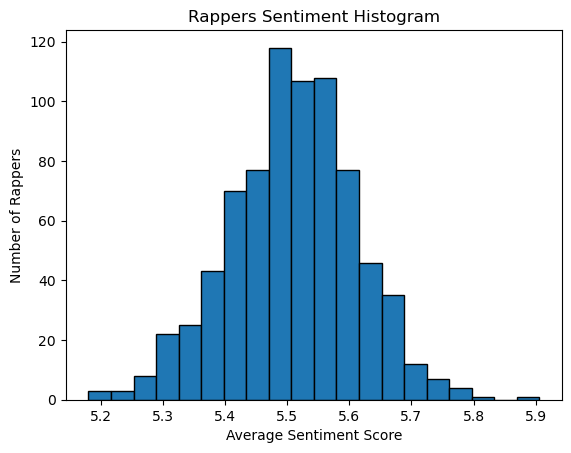

In [94]:
average_scores = [score for rapper, score in result]

# Create a histogram
plt.hist(average_scores, bins=20, edgecolor='k')
plt.title('Rappers Sentiment Histogram')
plt.xlabel('Average Sentiment Score')
plt.ylabel('Number of Rappers')
plt.grid(False)

# Show the histogram
plt.show()

### What are the 10 happiest and saddest pages?

In [95]:
# sort the list
sorted_result = sorted(result, key=lambda x: x[1], reverse=True)

# Get the top 10 happiest pages
top_10_happiest = sorted_result[:10]

# Get the bottom 10 saddest pages
bottom_10_saddest = sorted_result[-10:]

# Print the happiest and saddest pages
print("Top 10 Happiest Pages:")
for page, score in top_10_happiest:
    print(page,score)

print("\nBottom 10 Saddest Pages:")
for page, score in bottom_10_saddest:
    print(page,score)

Top 10 Happiest Pages:
DJ_Webstar 5.906
KC_Montero 5.799
Like_(record_producer) 5.786
Mark_Batson 5.78
Theo_Martins 5.769
Young_Music_DYMG 5.768
Foreknown_(rapper) 5.758
D_Smoke 5.75
Sky_Blu_(rapper) 5.745
MC_Yogi 5.739

Bottom 10 Saddest Pages:
Jimmy_Wopo 5.273
Bobby_Shmurda 5.267
Slow_Pain 5.263
AR-Ab 5.257
Cool_C 5.249
MC_Trouble 5.246
Hell_Rell 5.231
Ol'_Dirty_Bastard 5.211
Droop-E 5.201
Slip_Capone 5.18


## 4.2 Sentiment of each coast

In this section, we are going to compute the average sentiment of each coast. Then based on the results we are going to analyze
> * which is the happiest and which is saddest coast
> * if the coast with the highest wikipedia page sentiment has a page sentiment that is significantly higher (5% confidence bound) than a randomly selected group of rappers of the same size by using the "label shuffling test."

### The happiest and saddest coast

In [96]:
# filter out 0's
east_coast_scores = [score for score in east_coast_scores if score != 0]
west_coast_scores = [score for score in west_coast_scores if score != 0]

# Calculate the average sentiment scores for each coast
average_east_coast_score = round(sum(east_coast_scores) / len(east_coast_scores), 3)
average_west_coast_score = round(sum(west_coast_scores) / len(west_coast_scores), 3)

# Determine the happiest and saddest coast
happiest_coast = "East Coast" if average_east_coast_score > average_west_coast_score else "West Coast"
saddest_coast = "East Coast" if average_east_coast_score < average_west_coast_score else "West Coast"

# Print the results
print(f"The happiest coast is the {happiest_coast} with an average score of {average_east_coast_score if happiest_coast == 'East Coast' else average_west_coast_score}")
print(f"The saddest coast is the {saddest_coast} with an average score of {average_east_coast_score if saddest_coast == 'East Coast' else average_west_coast_score}")

The happiest coast is the West Coast with an average score of 5.516
The saddest coast is the East Coast with an average score of 5.505


There is no difference between the coasts.

### Label shuffling test

Our null hypothesis is "The average sentiment score of West Coast is not significantly higher than the score in a randomly selected group of same size" ie. they have identical expected values. 

First we need to create 1000 random average sentiment scores.

In [107]:
num_iterations = 1000

# Lists to store shuffled average scores
shuffled_scores = []
shuffled_result = []
all_scores = east_coast_scores + west_coast_scores

west_size = len(west_coast_scores)
east_size = len(east_coast_scores)
count = 0

# Repeat the shuffling process
for _ in range(num_iterations):
    shuffled_labels = ["East Coast"] * east_size + ["West Coast"] * west_size
    random.shuffle(shuffled_labels)  # Randomize the order

    # Create a list of tuples (label, score) by zipping shuffled_labels and all_scores
    shuffled_scores = list(zip(shuffled_labels, all_scores))
    
    # Filter only "West Coast" values from shuffled_scores
    random_west = [score for label, score in shuffled_scores if label == "West Coast"]

    # Calculate the average and store the shuffled scores
    shuffled_result.append(round(sum(random_west) / west_size, 3))

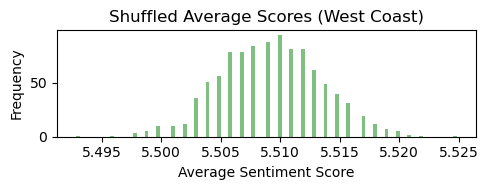

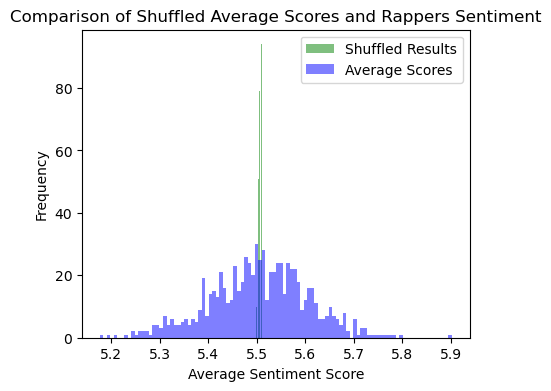

In [108]:
# Plot the results
plt.figure(figsize=(5, 2))
plt.hist(shuffled_result, bins=100, alpha=0.5, color='green', align="left")
plt.title('Shuffled Average Scores (West Coast)')
plt.xlabel('Average Sentiment Score')
plt.ylabel('Frequency')
plt.grid(False)  # Clear gridlines

plt.tight_layout()
plt.show()

# Create a figure with a single set of axes
fig, ax = plt.subplots(figsize=(5, 4))

# Plot the shuffled results
ax.hist(shuffled_result, bins=100, alpha=0.5, color='green', align="left", label='Shuffled Results')

# Plot the average scores of all rappers on the same axes
ax.hist(average_scores, bins=100, alpha=0.5, color='blue', align="left", label='Average Scores')

ax.set_title('Comparison of Shuffled Average Scores and Rappers Sentiment')
ax.set_xlabel('Average Sentiment Score')
ax.set_ylabel('Frequency')
ax.grid(False)

# Add a legend to distinguish the two datasets
ax.legend()

# Show the combined plot
plt.show()


The average score remains the same in all iterations and it is basically the same as the average sentiment score of West Coast (5.516.) When we compare the plot above to the histogram of all rappers, we can see that the variance is much smaller. 

Seems that these randomly generated average scores follows the normal distribution. Then we can compute the p-value to be sure that the confidence level is over 95%. We use ttest_ind  that is a two-sided test for the null hypothesis that two independent samples have identical average (expected values).

In [110]:
# Calculate the p-value
t_statistic, p_value = ttest_ind(west_coast_scores, shuffled_result, equal_var=False)

# Determine if the difference is statistically significant
alpha = 0.05  # Set your desired significance level
if p_value < alpha:
    print("The difference is statistically significant.")
else:
    print("The difference is not statistically significant.")

print("p-value:", p_value)

The difference is not statistically significant.
p-value: 0.2779670231155023


**Does the result make sense to you? Elaborate.**

The p-value is not less that 0.05 which confirms our original hypothesis that the expected values of these sets are not significantly different, which makes sense. P-value of approximately 27% means that the west_coast_score value cound be part of the shuffled_result distribution and therefore the difference between the coasts is not significant. We can conclude that both coasts are equally happy.